# Document Classification (movie genres)

In [12]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Pre-processing and cleaning

In [3]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv('/content/drive/MyDrive/movies_genres.csv', delimiter='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117352 entries, 0 to 117351
Data columns (total 30 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   title        117352 non-null  object
 1   plot         117352 non-null  object
 2   Action       117352 non-null  int64 
 3   Adult        117352 non-null  int64 
 4   Adventure    117352 non-null  int64 
 5   Animation    117352 non-null  int64 
 6   Biography    117352 non-null  int64 
 7   Comedy       117352 non-null  int64 
 8   Crime        117352 non-null  int64 
 9   Documentary  117352 non-null  int64 
 10  Drama        117352 non-null  int64 
 11  Family       117352 non-null  int64 
 12  Fantasy      117352 non-null  int64 
 13  Game-Show    117352 non-null  int64 
 14  History      117352 non-null  int64 
 15  Horror       117352 non-null  int64 
 16  Lifestyle    117352 non-null  int64 
 17  Music        117352 non-null  int64 
 18  Musical      117352 non-null  int64 
 19  My

In [4]:
# dataset: 117,352 movies / 28 genres
df_genres = df.drop(['plot', 'title'], axis=1)

counts = []
categories = list(df_genres.columns.values)
for i in categories:
    counts.append((i, df_genres[i].sum()))
df_stats = pd.DataFrame(counts, columns=['genre', '#movies'])
df_stats

,genre,#movies
0,Action,12381
1,Adult,61
2,Adventure,10245
3,Animation,11375
4,Biography,1385
5,Comedy,33875
6,Crime,15133
7,Documentary,12020
8,Drama,46017
9,Family,15442


<Axes: xlabel='genre'>

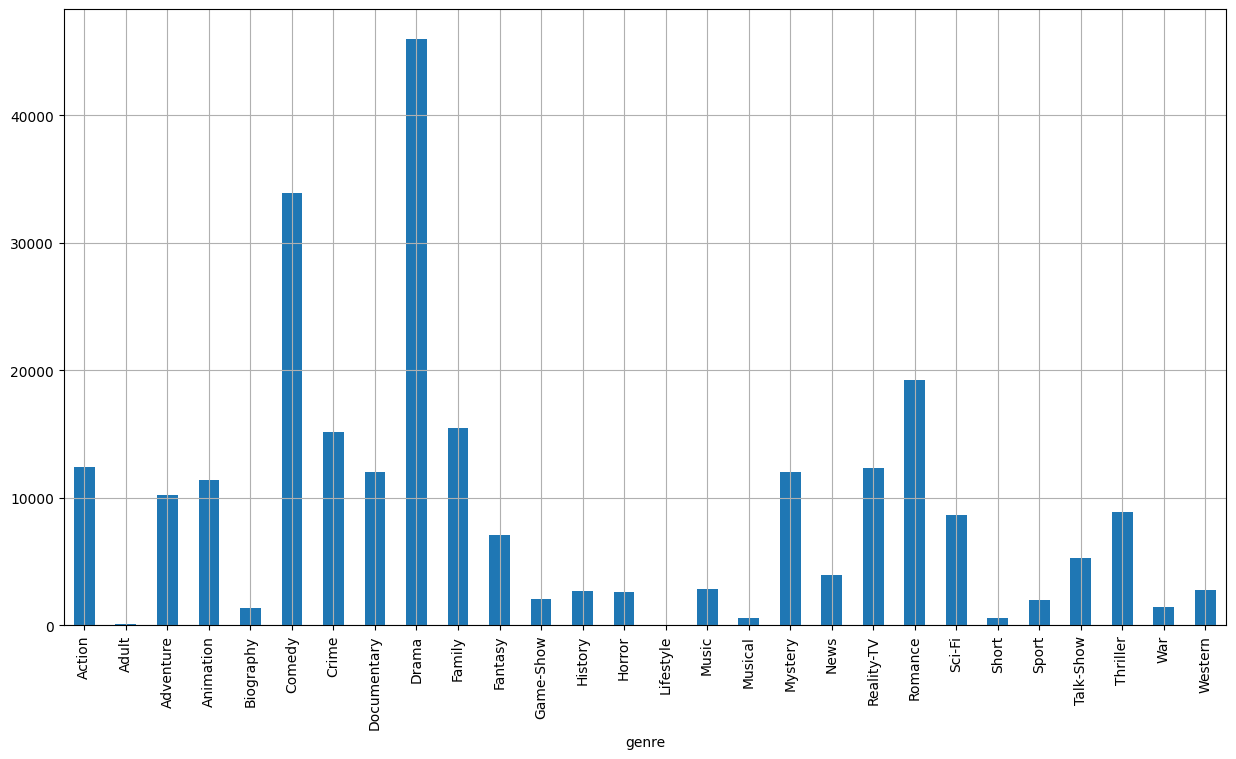

In [5]:
df_stats.plot(x='genre', y='#movies', kind='bar', legend=False, grid=True, figsize=(15, 8))

In [6]:
# Lifestyle has 0 instances -> remove it from the data set
df.drop('Lifestyle', axis=1, inplace=True)

In [8]:
!pip3 install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=574208e802b798d6981fefaeb3b44d1e87c1aa24f732fa4f9d290c411bf40fee
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [10]:
# dataset은 다양한 언어로 작성되어 있음
from langdetect import detect

#df['plot_lang'] = df.apply(lambda row: detect(row['plot'].decode("utf8")), axis=1)
df['plot_lang'] = df['plot'].apply(lambda text: detect(text))
df['plot_lang'].value_counts()

en    117196
nl       120
de        14
it         6
da         5
sv         2
es         2
no         2
fr         2
pt         2
hu         1
Name: plot_lang, dtype: int64

In [11]:
# keep English plots -> save this(en dataset) to a new file.
df = df[df.plot_lang.isin(['en'])]
df.to_csv('/content/drive/MyDrive/movies_genres_en.csv', sep='\t', encoding='utf-8', index=False)

In [14]:
data_df = pd.read_csv('/content/drive/MyDrive/movies_genres_en.csv', delimiter='\t')

In [19]:
# text에 해당하는 'plot' column만 사용 -> list로 저장
docs = list(data_df['plot'])
docs[:5]

[" #7dayslater is an interactive comedy series featuring an ensemble cast of YouTube celebrities. Each week the audience writes the brief via social media for an all-new episode featuring a well-known guest-star. Seven days later that week's episode premieres on TV and across multiple platforms.",
 ' With just one week left in the workshops, the women consider the idea of "The One." The ladies are stunned when Jahmil finally comes to a decision about Bentley and if he\'s the one for her. Jack challenges Tennesha to express her feelings of love towards Errol, but can she put herself out there and face possible rejection?',
 " All of the women start making strides towards finding their own version of a happy ending. Tennesha and Errol decide to become exclusive, but Laree just isn't ready to tell Karl she loves him, even though he has expressed that sentiment to her. Cynthia finds it hard to venture out on her own after her tumultuous separation, and Monet finally finds peace in her divo

In [22]:
# text preprocessing
def text_process(text):
  no_punc = [char for char in text if char not in string.punctuation]
  no_punc = ''.join(no_punc)

  return [word for word in no_punc.split() if word.lower() not in stopwords.words('english')]

In [26]:
print(docs[0])
print(text_process(docs[0]))

 #7dayslater is an interactive comedy series featuring an ensemble cast of YouTube celebrities. Each week the audience writes the brief via social media for an all-new episode featuring a well-known guest-star. Seven days later that week's episode premieres on TV and across multiple platforms.
['7dayslater', 'interactive', 'comedy', 'series', 'featuring', 'ensemble', 'cast', 'YouTube', 'celebrities', 'week', 'audience', 'writes', 'brief', 'via', 'social', 'media', 'allnew', 'episode', 'featuring', 'wellknown', 'gueststar', 'Seven', 'days', 'later', 'weeks', 'episode', 'premieres', 'TV', 'across', 'multiple', 'platforms']


In [27]:
# CountVectorizer 이용해서, bow(bag of words)로 변환!
## 개의 vocavulary의 자리가 있는것
bow_transformer = CountVectorizer(analyzer=text_process).fit(docs)
len(bow_transformer.vocabulary_)

218879

In [28]:
bow_0 = bow_transformer.transform([docs[0]])
print(bow_0)

  (0, 3528)	1
  (0, 108130)	1
  (0, 117479)	1
  (0, 132729)	1
  (0, 134911)	1
  (0, 136192)	1
  (0, 138680)	1
  (0, 143127)	1
  (0, 145287)	1
  (0, 145623)	1
  (0, 148192)	1
  (0, 152159)	1
  (0, 158020)	1
  (0, 158239)	2
  (0, 160933)	2
  (0, 166426)	1
  (0, 172603)	1
  (0, 175350)	1
  (0, 178983)	1
  (0, 181904)	1
  (0, 189660)	1
  (0, 191261)	1
  (0, 200314)	1
  (0, 203292)	1
  (0, 214864)	1
  (0, 216296)	1
  (0, 216319)	1
  (0, 216463)	1
  (0, 218080)	1


# Transformation to Doc-Term Matrix

In [29]:
# docs는 doc-term matrix 형태로 수치화됨
docs = bow_transformer.transform(docs)

In [30]:
print('Shape of Sparse Matrix: ', docs.shape)
print('Amount of Non-zero occurrences: ', docs.nnz)

Shape of Sparse Matrix:  (117196, 218879)
Amount of Non-zero Occurrences:  5692079


In [31]:
# NMF 적용을 위해서 Term-Document matrix로 순서를 바꾸어주어야 함
## transposed matrix로 바꾸자!
type(docs)

scipy.sparse._csr.csr_matrix

In [32]:
# csr_matrix(compresed sparse row matrix)인 docs를 transpose하자
## row: word / column: document
docs_trans = docs.transpose()
type(docs_trans)

scipy.sparse._csc.csc_matrix

In [33]:
print('Shape of Sparse Matrix: ', docs_trans.shape)
print('Amount of Non-zero Occurrences: ', docs_trans.nnz)

Shape of Sparse Matrix:  (218879, 117196)
Amount of Non-zero Occurrences:  5692079


# Model Define

In [34]:
from sklearn.decomposition import NMF
model = NMF(n_components=27)

In [35]:
W = model.fit_transform(docs_trans)
H = model.components_
H.shape    # (class 개수, documnet 개수)

(27, 117196)

In [36]:
# result -> 5번째 문서에 해당하는 clustering 점수를 확인해 보자
print(H[:,5])

[0.00414739 0.         0.03283013 0.00414733 0.00400815 0.02105839
 0.         0.         0.00251987 0.01487574 0.00503118 0.
 0.00306289 0.02048132 0.01302875 0.         0.         0.
 0.         0.00674244 0.00283382 0.         0.00331691 0.00367867
 0.         0.         0.00322599]


In [37]:
# 전체문서별 best score에 해당하는 cluster label
## 어떤 index가 best였는지 확인해 보자
pred_labels = H.argmax(axis=0)
len(pred_labels)

117196

In [38]:
pred_labels

array([ 9,  3,  6, ...,  4, 26,  8])

In [39]:
# H values of doc0, doc1, doc2
H[:,:3]

array([[7.05773066e-04, 6.86648409e-03, 0.00000000e+00],
       [4.30146972e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.66691149e-03, 0.00000000e+00],
       [4.19055889e-03, 2.02293349e-01, 0.00000000e+00],
       [0.00000000e+00, 1.41904070e-03, 0.00000000e+00],
       [0.00000000e+00, 2.18440404e-04, 0.00000000e+00],
       [0.00000000e+00, 4.24131747e-02, 2.07024767e-01],
       [0.00000000e+00, 5.79737577e-04, 0.00000000e+00],
       [3.63518809e-03, 0.00000000e+00, 0.00000000e+00],
       [9.65420770e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.83831046e-05],
       [1.49408061e-02, 1.50560304e-02, 0.00000000e+00],
       [2.10201110e-03, 0.00000000e+00, 7.29235970e-03],
       [0.00000000e+00, 3.14918970e-03, 0.00000000e+00],
       [0.00000000e+00, 6.16781100e-03, 0.00000000e+00],
       [0.00000000e+00, 3.56494

In [44]:
# category information => 정답 matrix
data_y = data_df.drop(['title', 'plot', 'plot_lang'], axis=1).to_numpy()
data_y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [46]:
len(data_y)

117196

In [41]:
# category information => 정답 matrix
target = list(data_y.argmax(axis=1))

117196

In [47]:
# target -> 실제 정답을 list화 한 것
target = list(data_y.argmax(axis=1))

In [48]:
# 실제 label과 predicted cluster를 비교해 보자
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(target, pred_labels))

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,934,8,1061,999,742,46,2372,15,483,310,...,123,242,377,665,192,90,439,116,144,360
1,7,0,0,6,1,0,7,0,3,7,...,0,1,3,3,2,1,0,5,0,1
2,431,9,29,442,243,31,1210,16,171,236,...,44,122,175,302,97,54,109,72,51,83
3,510,3,41,499,108,20,1804,32,354,400,...,21,172,167,475,174,187,101,95,63,36
4,44,37,1,145,49,14,156,1,54,158,...,3,31,51,21,6,6,15,24,12,50
5,1658,501,219,1472,887,245,6781,70,1203,2492,...,259,378,572,948,820,675,262,428,301,260
6,478,5,45,840,1024,77,1106,7,228,214,...,147,103,339,357,147,73,293,215,97,1446
7,477,94,28,1047,291,131,1418,34,480,1124,...,24,227,391,241,96,79,269,292,38,232
8,2025,81,113,903,850,202,5880,66,762,577,...,204,271,303,1070,750,227,153,426,1219,370
9,175,110,19,185,47,12,551,5,109,371,...,10,47,73,151,68,66,36,62,24,20


In [51]:
cmatrix = confusion_matrix(target, pred_labels)
cmatrix[:,:3]   # 3개의 document를 확인해 보자

array([[ 934,    8, 1061],
       [   7,    0,    0],
       [ 431,    9,   29],
       [ 510,    3,   41],
       [  44,   37,    1],
       [1658,  501,  219],
       [ 478,    5,   45],
       [ 477,   94,   28],
       [2025,   81,  113],
       [ 175,  110,   19],
       [  35,    0,    1],
       [  24,   37,    1],
       [  23,    1,    2],
       [  22,    0,    2],
       [  17,    8,    0],
       [   1,    0,    0],
       [  15,    1,    1],
       [  51,  627,   12],
       [ 519,   81,   37],
       [  21,    3,    5],
       [  35,    1,    5],
       [   1,    0,    0],
       [  33,    0,    3],
       [  51,  434,   10],
       [   9,    0,    1],
       [   2,    0,    0],
       [ 159,    6,   14]])

In [52]:
# 각 cluster의 문서마다 실제 label을 확인한 뒤, 가장 빈도수가 높은 것을 해당 cluster의 label로 한다.
# 위에서 확인한 3개의 문서에서 cluster label은 가장 빈도수가 높은 index number로 결정된다. (1번째열-8번째, 2번째열-17번째, 3번째열-0번째)
cmatrix[:,:3].argmax(axis=0)

array([ 8, 17,  0])

In [53]:
cmatrix

array([[ 934,    8, 1061,  999,  742,   46, 2372,   15,  483,  310,  525,
         432,  827,  486,   35,  253,  100,  123,  242,  377,  665,  192,
          90,  439,  116,  144,  360],
       [   7,    0,    0,    6,    1,    0,    7,    0,    3,    7,    8,
           2,    0,    1,    0,    2,    0,    0,    1,    3,    3,    2,
           1,    0,    5,    0,    1],
       [ 431,    9,   29,  442,  243,   31, 1210,   16,  171,  236,  185,
         148,  329,  286,   16,  200,   44,   44,  122,  175,  302,   97,
          54,  109,   72,   51,   83],
       [ 510,    3,   41,  499,  108,   20, 1804,   32,  354,  400,  423,
         129,  372,  265,   13,  260,   17,   21,  172,  167,  475,  174,
         187,  101,   95,   63,   36],
       [  44,   37,    1,  145,   49,   14,  156,    1,   54,  158,   17,
          59,   15,  211,    4,   75,   16,    3,   31,   51,   21,    6,
           6,   15,   24,   12,   50],
       [1658,  501,  219, 1472,  887,  245, 6781,   70, 1203, 249

In [54]:
set(cmatrix.argmax(axis=0))

{0, 5, 6, 7, 8, 17, 19}

In [56]:
selected_column = data_df.drop(['title', 'plot', 'plot_lang'], axis=1).iloc[:, [0, 5, 6, 7, 8, 17, 19]]
selected_column

,Action,Comedy,Crime,Documentary,Drama,News,Romance
0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
117191,0,0,1,0,1,0,0
117192,0,0,1,0,1,0,0
117193,0,0,1,0,1,0,0
117194,0,0,1,0,1,0,0


In [57]:
# 결과를 list화 해서 저장
list(cmatrix.argmax(axis=0))

[8,
 17,
 0,
 5,
 6,
 19,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 7,
 8,
 8,
 8,
 5,
 5,
 5,
 8,
 5,
 5,
 0,
 5,
 8,
 6]

In [58]:
best_labels = list(cmatrix.argmax(axis=0))

i = 0
sum_result = 0
for c in cmatrix.transpose():
  print(c)
  print('label:', best_labels[i])
  print('value:', c[best_labels[i]])
  sum_result += c[best_labels[i]]
  i += 1

print('sum_result:', sum_result)

[ 934    7  431  510   44 1658  478  477 2025  175   35   24   23   22
   17    1   15   51  519   21   35    1   33   51    9    2  159]
label: 8
value: 2025
[  8   0   9   3  37 501   5  94  81 110   0  37   1   0   8   0   1 627
  81   3   1   0   0 434   0   0   6]
label: 17
value: 627
[1061    0   29   41    1  219   45   28  113   19    1    1    2    2
    0    0    1   12   37    5    5    0    3   10    1    0   14]
label: 0
value: 1061
[ 999    6  442  499  145 1472  840 1047  903  185   38  211   45   45
   30    2   33   95  785   12   37    8   54  100   21    3  137]
label: 5
value: 1472
[ 742    1  243  108   49  887 1024  291  850   47   26    7   19   37
    8    1   16   28  223   13   14    0    4   48   14    0  311]
label: 6
value: 1024
[ 46   0  31  20  14 245  77 131 202  12   1  23   4  10  13   0   1  81
  43 271   2   1  14  42   1   0  12]
label: 19
value: 271
[2372    7 1210 1804  156 6781 1106 1418 5880  551   74  136   68   71
   42    3   39  165 1648   6

In [59]:
sum_result / len(data_y)

0.26823441073074167